In [72]:
%matplotlib inline
import numpy as np
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray
from scipy.signal import welch
from handy_functions import circmean

In [77]:
plt.rc('font',size=14)

In [3]:
dataPaths = {
    'LES_25'  :'/glade/scratch/doubrawa/postProcessing',
    'LES_100' :'/glade/scratch/doubrawa/postProcessing',
    'LES_333' :'/glade/scratch/doubrawa/VLES',
    'SH_333'  :'/glade/scratch/doubrawa/SH',
    'MYNN_333':'/glade/scratch/doubrawa/MYNN'}

keysOrdered = ['LES_100','LES_333','MYNN_333','SH_333']

gray = '#85929E'
light_gray = '#AEB6BF'
red = '#A93226'
blue = '#2980B9'
yellow = '#D4AC0D'

lineColors = {
    'LES_25'  :'k',
    'LES_100' :gray,
    'LES_333' :yellow,
    'SH_333'  :red,
    'MYNN_333':blue}

markers = {
    'LES_25'  :'o',
    'LES_100' :'x',
    'LES_333' :'s',
    'SH_333'  :'^',
    'MYNN_333':'v'}

markerSizes = {
    'LES_25'  :1,
    'LES_100' :1,
    'LES_333' :1,
    'SH_333'  :0.1,
    'MYNN_333':1}

markerWidths = {
    'LES_25'  :1,
    'LES_100' :1,
    'LES_333' :1,
    'SH_333'  :1,
    'MYNN_333':1}

lineWidths = {
    'LES_25'  :2,
    'LES_100' :2,
    'LES_333' :2,
    'SH_333'  :2,
    'MYNN_333':2}

alphas = {
    'LES_25'  :0.7,
    'LES_100' :1,
    'LES_333' :1,
    'SH_333'  :1,
    'MYNN_333':1}

In [103]:
labels = {'WS':'Horizontal Wind Speed',
          'WD':'Wind Direction',
          'T':'Potential Temperature',
          'W':'Vertical Velocity'}

units = {'WS':'m/s', 'WD':'deg', 'T':'K',
         'W':'m/s'}

In [349]:
terrain              = 1580.
dayOfInterestUTC     = 28
dayOfSimulationStart = dayOfInterestUTC-1
variablesToRead      = ['U','V','W','T']
variablesToPlot      = ['WS','WD','T']

In [5]:
def date_parser(startDay,deltas):
    return pd.to_datetime('2015-03-{0}'.format(startDay)) + pd.to_timedelta(deltas, unit='h')

In [10]:
data = {dataKey:{} for dataKey in dataPaths.keys()}

Read in domingo's data

In [20]:
for dataKey in ['LES_25','LES_100']:
    for  varName in variablesToRead:
        fNames = glob.glob(os.path.join(dataPaths[dataKey],'*{0}*_40.0*_{1}_2015-03-{2}*'.format(dataKey,varName,dayOfInterestUTC)))
        for fName in fNames:            
            print os.path.split(fName)[-1]
            data[dataKey][varName] = pd.read_csv(fName,index_col=[0],parse_dates=[0])
            data[dataKey][varName].columns = range(len(data[dataKey][varName].columns))

LES_25m_40.050_-105.005_U_2015-03-28.csv
LES_25m_40.050_-105.005_V_2015-03-28.csv
LES_25m_40.050_-105.005_W_2015-03-28.csv
LES_25m_40.050_-105.005_T_2015-03-28.csv
LES_100m_40.052_-105.005_U_2015-03-28.csv
LES_100m_40.052_-105.005_V_2015-03-28.csv
LES_100m_40.052_-105.005_W_2015-03-28.csv
LES_100m_40.052_-105.005_T_2015-03-28.csv


Read in my data

In [304]:
variablesToRead = ['U','V','W','T','PH']

In [305]:
for dataKey in ['LES_333','SH_333','MYNN_333']:
    for varName in variablesToRead:
        varName = 'TH' if varName=='T' else varName
        fNames = glob.glob(os.path.join(dataPaths[dataKey], \
                                 '03{0}15'.format(dayOfInterestUTC), \
                                 'bao.d03.{0}*'.format(varName)))
        for fName in fNames:
            print fName
            data[dataKey][varName] = pd.read_csv(fName, skiprows=1, header=None, delim_whitespace=True, index_col=[0])
            data[dataKey][varName].index = date_parser(dayOfSimulationStart,data[dataKey][varName].index)
            data[dataKey][varName].columns = range(len(data[dataKey][varName].columns))
    if 'T' in variablesToRead:
        data[dataKey]['T'] = data[dataKey]['TH']

/glade/scratch/doubrawa/VLES/032815/bao.d03.UU
/glade/scratch/doubrawa/VLES/032815/bao.d03.VV
/glade/scratch/doubrawa/VLES/032815/bao.d03.WW
/glade/scratch/doubrawa/VLES/032815/bao.d03.TH
/glade/scratch/doubrawa/VLES/032815/bao.d03.PH
/glade/scratch/doubrawa/SH/032815/bao.d03.UU
/glade/scratch/doubrawa/SH/032815/bao.d03.VV
/glade/scratch/doubrawa/SH/032815/bao.d03.WW
/glade/scratch/doubrawa/SH/032815/bao.d03.TH
/glade/scratch/doubrawa/SH/032815/bao.d03.PH
/glade/scratch/doubrawa/MYNN/032815/bao.d03.UU
/glade/scratch/doubrawa/MYNN/032815/bao.d03.VV
/glade/scratch/doubrawa/MYNN/032815/bao.d03.WW
/glade/scratch/doubrawa/MYNN/032815/bao.d03.TH
/glade/scratch/doubrawa/MYNN/032815/bao.d03.PH


Convert everything to the local timezone

In [100]:
for dataKey in keysOrdered:
    for varKey in data[dataKey].keys():
        data[dataKey][varKey] = data[dataKey][varKey].tz_localize('UTC').tz_convert('US/Mountain').copy()        

Compute wind speed and wind direction

In [60]:
for dataKey in keysOrdered:
    data[dataKey]['WS'] = np.sqrt(data[dataKey]['U']**2 + data[dataKey]['V']**2)
    data[dataKey]['WD'] = np.arctan2( data[dataKey]['U'], data[dataKey]['V'] )
    data[dataKey]['WD'] *= 180.0/np.pi  
    data[dataKey]['WD'] += 180.0

Visualize timeseries

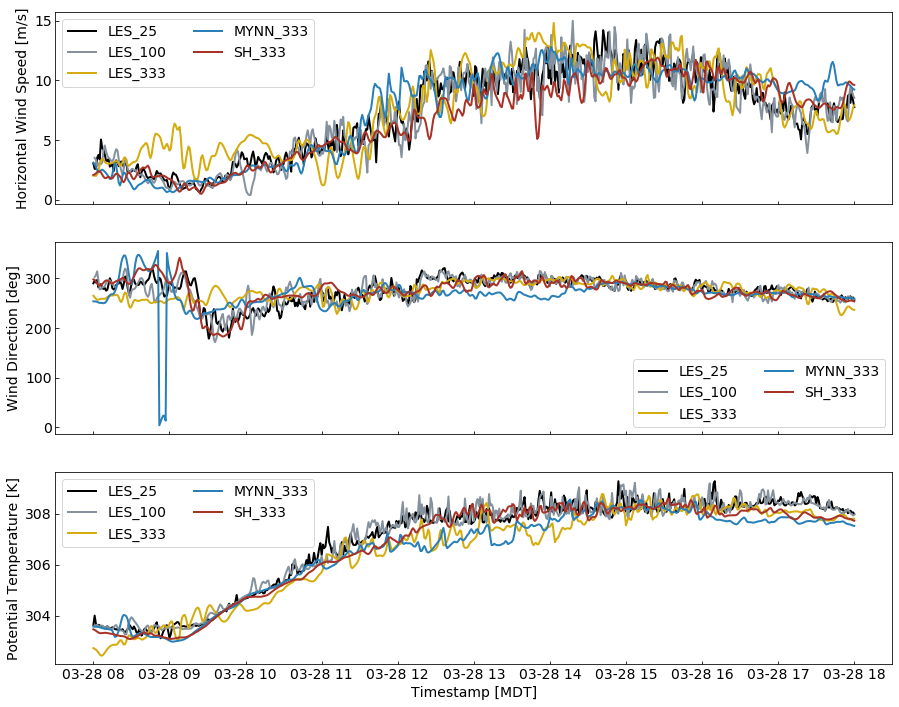

In [102]:
keysOrdered = ['LES_25','LES_100','LES_333','MYNN_333','SH_333']

k       = 8
fig     = plt.figure(figsize=(15,12))
ax      = {}

for iax,varName in enumerate(variablesToPlot):

    if iax==0:        
        ax[iax] = fig.add_subplot(len(variablesToPlot),1,iax+1)
    else:
        ax[iax] = fig.add_subplot(len(variablesToPlot),1,iax+1,sharex=ax[0])

    for dataKey in keysOrdered:
        series = data[dataKey][varName][k].loc['2015-03-28 08:00':'2015-03-28 18:00'].copy()
        
        if varName=='WD':
            series = series.resample('1min').apply(circmean)
        else:
            series = series.resample('1min').mean()

        x = series.index
        y = series.values
        
        ax[iax].plot(x,y,label=dataKey,
                color=lineColors[dataKey],
                marker='None',
                markersize=0.1,
                linewidth=lineWidths[dataKey],
                markeredgewidth=1)
        ax[iax].set_ylabel('{0} [{1}]'.format(labels[varName], units[varName]))    
    ax[iax].legend(ncol=2)
    
    ax[iax].tick_params(which='both',direction='in')    
    if iax in [0,1]:
        plt.setp(ax[iax].get_xticklabels(), visible=False)
        
ax[iax].set_xlabel('Timestamp [MDT]')        
fig.subplots_adjust(hspace=0.2)        

Visualize spectra

In [104]:
variablesToPlot = ['WS','W','T']

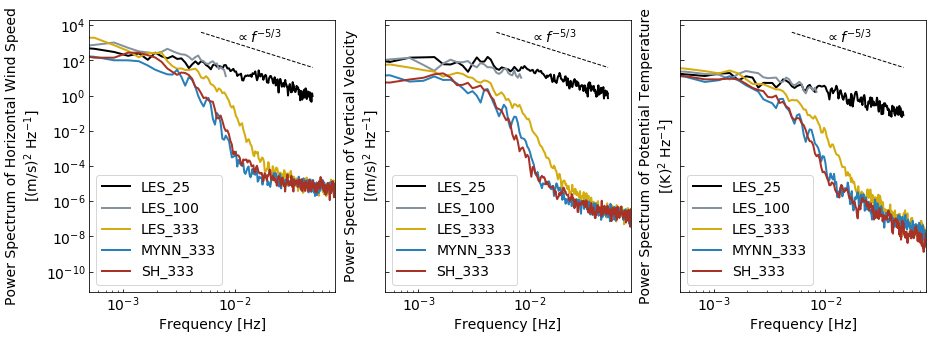

In [295]:
keysOrdered = ['LES_25','LES_100','LES_333','MYNN_333','SH_333']

k       = 8
fig     = plt.figure(figsize=(15,5))
ax      = {}

for iax,varName in enumerate(variablesToPlot):

    if iax==0:        
        ax[iax] = fig.add_subplot(1,len(variablesToPlot),iax+1)
    else:
        ax[iax] = fig.add_subplot(1,len(variablesToPlot),iax+1,sharex=ax[0],sharey=ax[0])

    for dataKey in keysOrdered:
        
        series = data[dataKey][varName][k].loc['2015-03-28 14:00':'2015-03-29 00:00'].copy()        
        series = series - series.mean()

        dt     = np.mean( np.unique(np.diff(series.index))/ np.timedelta64(1, 's') )
        secPerSeg = 3600
        nPerSeg = secPerSeg/dt

        f, P = welch(series.values, 1/dt, nperseg=nPerSeg)
        df = np.mean(np.diff(f))
        
        x = f
        y = P
        
#         print "Dataset : {0}; Variable : {1}".format(dataKey,varName)
#         print "Variance from data     : {0:.2f}".format(np.var(series))
#         print "Variance from spectrum : {0:.2f}".format(np.sum(y*df))        
#         print " "
        
        ax[iax].loglog(x,y,label=dataKey,
                color=lineColors[dataKey],
                marker='None',
                markersize=0.1,
                linewidth=lineWidths[dataKey],
                markeredgewidth=1)
        ax[iax].set_xlabel('Frequency [Hz]')
        ax[iax].set_ylabel("Power Spectrum of {0}".format(labels[varName])+"\n"+"[({0})$^{{2}}$ Hz$^{{-1}}$]".format(units[varName]))
    ax[iax].legend(ncol=1)
    
    ax[iax].tick_params(which='both',direction='in')    
    if iax>0:
        plt.setp(ax[iax].get_yticklabels(), visible=False)
    
    if varName!='T':
        ref_f     = np.linspace(5e-3,5e-2,20)
        ref_slope = ref_f**(-5/3) * 1e-1
        ax[iax].loglog(ref_f,ref_slope,'--k',lw=1)
        ax[iax].text(1e-2,1e3,'$\propto f^{{-5/3}}$')       
    else:
        ref_f     = np.linspace(5e-3,5e-2,20)
        ref_slope = ref_f**(-5/3) * 1e-1
        ax[iax].loglog(ref_f,ref_slope,'--k',lw=1)
        ax[iax].text(1e-2,1e3,'$\propto f^{{-5/3}}$')       

        
    ax[iax].set_xlim([5e-4,8e-2])

fig.subplots_adjust(wspace=0.2)    

Visualize diurnal cycle

In [302]:
variablesToPlot = ['WS','T']

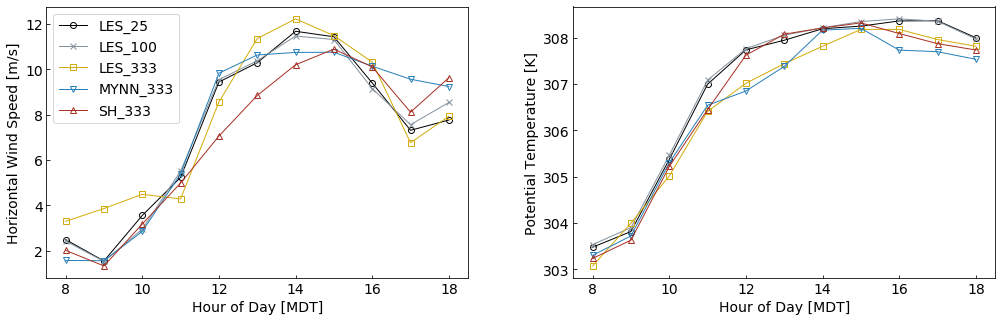

In [303]:
keysOrdered = ['LES_25','LES_100','LES_333','MYNN_333','SH_333']

k       = 8
fig     = plt.figure(figsize=(17,5))
ax      = {}

for iax,varName in enumerate(variablesToPlot):

    if iax==0:        
        ax[iax] = fig.add_subplot(1,len(variablesToPlot),iax+1)
    else:
        ax[iax] = fig.add_subplot(1,len(variablesToPlot),iax+1,sharex=ax[0])

    for dataKey in keysOrdered:
        
        series = data[dataKey][varName][k].loc['2015-03-28 08:00':'2015-03-28 18:00']
        series = series.groupby(series.index.hour).median()

        x = series.index
        y = series.values
        
        ax[iax].plot(x,y,label=dataKey,
                color=lineColors[dataKey],
                marker=markers[dataKey],
                markersize=6,
                linewidth=1,
                mfc='None',
                markeredgewidth=1)
        
    ax[iax].set_xlabel('Hour of Day [MDT]')
    ax[iax].set_xticks(np.arange(8,20,2))
    ax[iax].set_ylabel('{0} [{1}]'.format(labels[varName],units[varName]))    
    ax[iax].tick_params(which='both',direction='in')    

    if iax==0:
        ax[iax].legend(ncol=1)
    
fig.subplots_adjust(wspace=0.25)    

Attempt at profiles

In [357]:
dataKey = 'LES_333'

In [358]:
nt, nz = data[dataKey]['T'].shape
theta_grid = np.zeros((nz,nt))

In [360]:
(data['LES_333']['PH']/9.81).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,5.184000e+04,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000,51840.000000
mean,1.613795e+02,162.526221,163.745328,165.041684,166.420235,167.886094,169.444971,171.102830,172.865921,174.740839,176.734534,178.854555,181.108893,183.505997,186.054944,188.765264,191.647178
std,1.507786e-10,0.013435,0.024228,0.035193,0.046226,0.057409,0.068682,0.079947,0.091267,0.102829,0.114713,0.126980,0.139663,0.152778,0.166328,0.180339,0.194860
min,1.613795e+02,162.495271,163.693788,164.969927,166.329312,167.776747,169.317409,170.956212,172.700013,174.556615,176.533507,178.633888,180.866841,183.242583,185.770160,188.458881,191.318797
25%,1.613795e+02,162.517720,163.726265,165.011463,166.378215,167.831573,169.377188,171.021366,172.770804,174.631848,176.611664,178.717392,180.956981,183.338746,185.871755,188.566006,191.432219
50%,1.613795e+02,162.533286,163.757797,165.059382,166.442914,167.913626,169.477282,171.139449,172.906669,174.785686,176.783533,178.907494,181.165683,183.566661,186.119834,188.834486,191.720460
75%,1.613795e+02,162.536671,163.764865,165.070731,166.459010,167.934630,169.503240,171.171037,172.945162,174.831578,176.836757,178.968760,181.235566,183.646647,186.209588,188.934348,191.831630
max,1.613795e+02,162.541959,163.775740,165.087131,166.481135,167.962877,169.537919,171.212361,172.992360,174.884649,176.896258,179.034617,181.307875,183.724232,186.292748,189.022942,191.924843


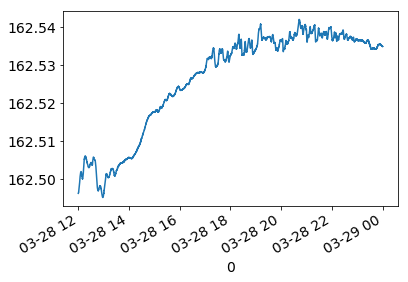

In [356]:
z[1].plot()

In [340]:
plt.plot()

TypeError: unhashable type

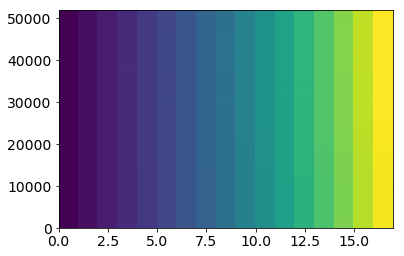

In [338]:
plt.pcolormesh(z)

In [330]:
theta_grid[:,:] = data[dataKey]['T'].values.T

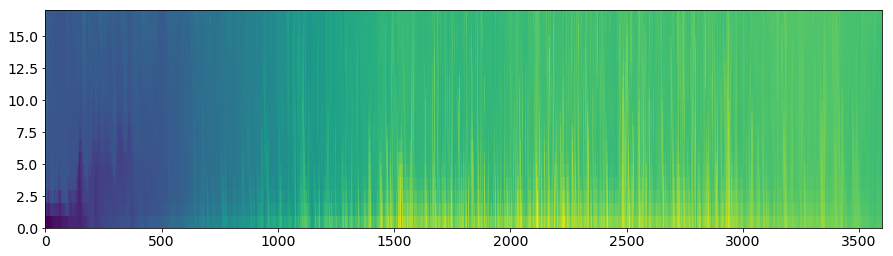

In [331]:
fig = plt.figure(figsize=(15,4))
ax  = fig.add_subplot(111)
ax.pcolormesh(theta_grid)